https://docs.pymc.io/notebooks/GLM-linear.html
https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.MvNormal

In this post we study the Regularized Bayesian Regression model to explore the weight-space view of Gaussian Process Regression described in the book [Gaussian Processes for Machine Learning, Ch 2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf). We follow this reference very closely (an encourage to read it!). Our main objective is to ilustrate the concepts and results through a concrete example. We use [PyMC3](https://docs.pymc.io) to run bayesian sampling. See [this](https://juanitorduz.github.io/intro_pymc3/) post for an introduction to bayesian methods and PyMC3.

Let us consider the model:

$$
f(x) = x^T b \quad \text{and} \quad y = f(x) + \varepsilon, \quad \text{with} \quad \varepsilon \sim N(0, \sigma_n^2)
$$

where \\(x \in \mathbb{R}^d\\) is a vector of data and \\(b \in \mathbb{R}^d\\) is the vector of weights (parameters). We assume a bias weight is included in \\(b\\).  

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import pymc3 as pm

import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

## Generate Sample Data

Let us begin by generating sample data.

In [2]:
# Define dimension.
d = 2

# Number of samples. 
n = 100

# Independent variable. 
x = np.linspace(start=0, stop=1, num=n).reshape([1, n])

# Design matrix. We add a column of ones to account for the biad term. 
X = np.append(np.ones(n).reshape([1, n]), x, axis=0)

Now we generate the response variable.

In [3]:
# True parameters. 

b = np.zeros(d)
## Intercept. 
b[0] = 1
## Slope. 
b[1] = 3

b = b.reshape(d, 1)

# Error standar deviation. 
sigma_n = 0.5

# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n).reshape([n, 1])

f = np.dot(X.T, b)

# Observer target variable. 
y = f + epsilon

We visualize the data set.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


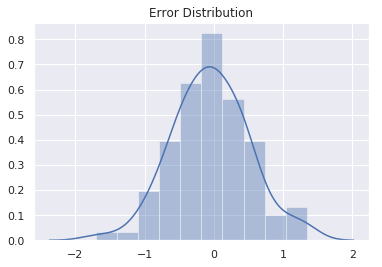

In [4]:
sns.distplot(epsilon).set_title("Error Distribution");

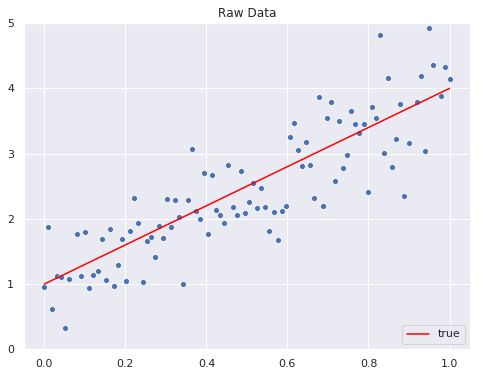

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
# Plot raw data.
sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));
# Plot "true" linear fit.
sns.lineplot(x=x.T.reshape(n,), y=f.reshape(n,), color="red", label = "true");

ax.set_ylim((0,5));
ax.legend(loc="lower right")
ax.set_title("Raw Data");

## Likehood

A straightforward calculation shows that the likehood function is given by

$$
p(y|X, b) = 
\frac{1}{(2\pi \sigma_n^2)^{n/2}} \exp\left(-\frac{1}{2\sigma_n^2}||y - X^T b||^2\right) = 
N(X^T b, \sigma_n^2 I)
$$

## Prior Distribution

We set a multivariate normal with mean zero distribution for the prior of the vector of weights \\(b \sim N(0, \Sigma_p)\\). Here \\(\Sigma_p \in M_{d}(\mathbb{R})\\) denotes the covariance matrix. 

In [6]:
# Mean vector.
mu_0 = np.zeros(d)
# Covariance matrix. 
sigma_p = np.array([[2, 1], [1, 2]]) + 1e-12*np.eye(d)

Let us sample from the prior distribution to see the level curves (see [here](https://juanitorduz.github.io/multivariate_normal/)). 

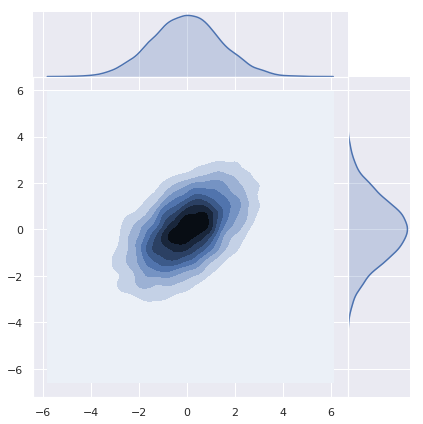

In [7]:
m = 10000

z = np.random.multivariate_normal(mean=mu_0, cov=sigma_p, size=m)

z = z.T

sns.jointplot(x=z[0],
              y=z[1], 
              kind="kde", 
              space=0);

Note that the ellipse-like level curves are rotated (with respect the natural axis) due the fact that \\(\Sigma_p\\) is not diagonal. 

## Posterior Distribution

Now we want to use the data to find the posterior destribution of the vector of weights. Recall that the posterior is obtained (from Bayes rule) by computing 

$$
\text{posterior} =
\frac{\text{likelihood × prior}}{\text{marginal likelihood}}
$$

Concretely, 

$$
p(b|y, X) = 
\frac{p(y|X, b)p(b)}{p(y|X)}
$$

The marginal likehood \\(p(y|X)\\), which is independent of \\(b\\), is calculated as 

$$
p(y|X) = \int p(y|X, b)p(b) db
$$

### MCMC Sampling with PyMC3

Recall that we do not need to compute \\(p(y|X)\\) since we can sample from the posterior distribution using [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling. Again, see [this](https://juanitorduz.github.io/intro_pymc3/) for more details. 

In [8]:
import theano.tensor as tt

model = pm.Model()

with model:
    
    # Define prior.
    beta = pm.MvNormal("beta", mu=mu_0, cov=sigma_p, shape=d)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=tt.dot(X.T, beta), sd=sigma_n, observed=y.squeeze())
    
    # Consider 6000 draws and 3 chains.
    trace = pm.sample(draws=6000, njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta]
Sampling 3 chains: 100%|██████████| 19500/19500 [00:10<00:00, 1840.64draws/s]


Let us visualize the posterior distributions. 

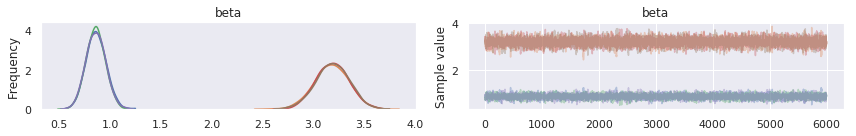

In [9]:
pm.traceplot(trace);

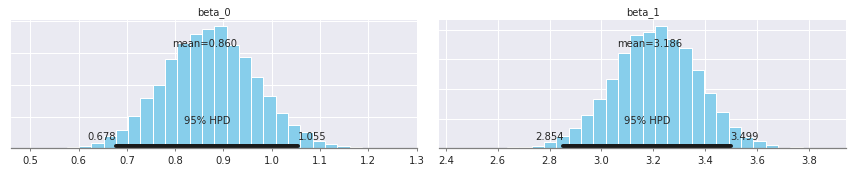

In [10]:
pm.plot_posterior(trace);

In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,0.860357,0.096256,0.001364,0.678067,1.054673,5181.502443,1.000353
beta__1,3.186192,0.165376,0.002254,2.853784,3.498872,5199.021713,1.000340


In addition, let us see the join posterior distribution. 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


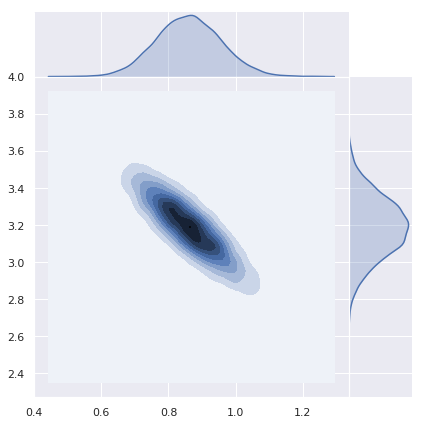

In [12]:
sns.jointplot(x=trace["beta"].T[0],
              y=trace["beta"].T[1], 
              kind="kde", 
              space=0);

### Analytical Solution

$$
p(b|y, X) \propto 
\exp\left(
-\frac{1}{2\sigma_n^2}||y - X^T b||^2
\right)
\exp\left(
-\frac{1}{2} b^T \Sigma_p b
\right)
$$

$$
A:= \sigma_n^{-2}XX^T + \Sigma_p^{-1} \in M_{d}(\mathbb{R})
\quad
\text{and}
\quad
\bar{b}:= \sigma_n^{-2}AXy
$$

Let us compute the analytic solution:

In [13]:
A = (sigma_n)**(-2)*np.dot(X, X.T) + np.linalg.inv(sigma_p)
A_inv = np.linalg.inv(A)

In [14]:
b_bar = (sigma_n)**(-2)*np.dot(A_inv, np.dot(X, y))
b_bar

array([[0.86110061],
       [3.18468264]])

Note that these values coincide with the values above obtained from the MCMC sampling. Let us sample from the analytical solution of the posterior distribution.

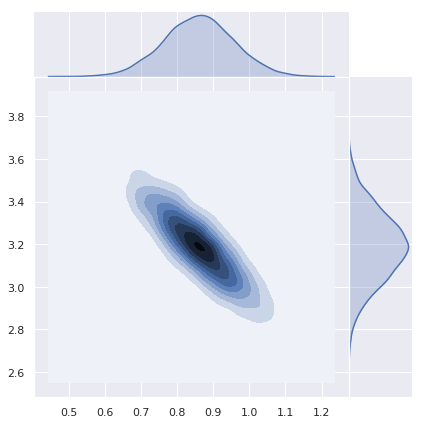

In [15]:
m = 10000

z = np.random.multivariate_normal(mean=b_bar.squeeze(), cov=A_inv, size=m)

z = z.T

sns.jointplot(x=z[0],
              y=z[1], 
              kind="kde", 
              space=0);

These level curves coinncide with the ones obtained above. 

## Predictions

Next, we use the posterior distribution of the weights vector to generate predictions. 

### Parameter Mean

Let us begin by using the mean of the posterior distribution of each parameter to find the linear fit.

In [16]:
# Compute mean of the posterior distribution. 
beta_hat = (np.apply_over_axes(func=np.mean, a=trace["beta"], axes=0)
            .squeeze()
            .reshape(d,1))

# Compute lineear fit. 
y_hat = np.dot(X.T, beta_hat)

Let us plot the result. 

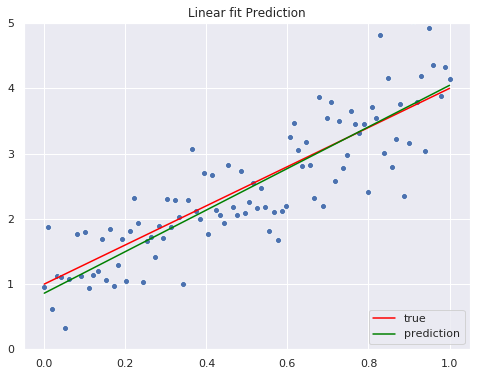

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

# Plot raw data.
sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));
# Plot "true" linear fit.
sns.lineplot(x=x.T.reshape(n,), y=f.reshape(n,), color="red", label = "true");
# Plot line corresponding to the posterior mean of the weight vector. 
sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green", label = "prediction");

ax.set_ylim((0,5));
ax.legend(loc="lower right")
ax.set_title("Linear fit Prediction");

### Confidence Inteval 

Next, let us compute the confidence interval for the fit. 

In [18]:
# We sample from the posterior. 
y_hat_samples = np.dot(X.T, trace["beta"].T)

In [19]:
# Compute the standard deviation. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

Let us plot the confidence interval corrsponding to a corridor coresponding to two standard deviations. 

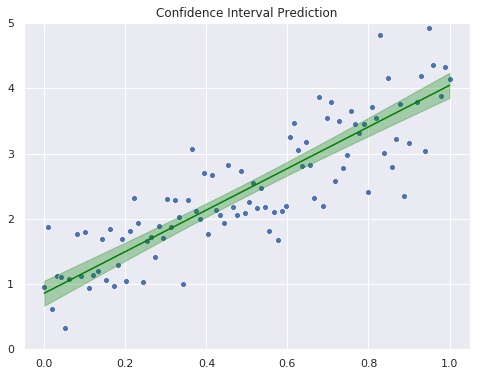

In [20]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green");

plt.fill_between(x=x.T.reshape(n,), 
                 y1=(y_hat.reshape(n,) - 2*y_hat_sd), 
                 y2=(y_hat.reshape(n,) + 2*y_hat_sd), 
                 color = "green", alpha = 0.3)

ax.set_ylim((0,5));
ax.set_title("Confidence Interval Prediction");

### Test Set

Now, we write a function to generate predictions for a new data point. 

In [21]:
def generate_prediction(x_star):
    # Compute prediction distribution. 
    prob = np.dot(x_star.T, trace["beta"].T)
    # Sample from it. 
    y_hat = np.random.choice(a=prob.squeeze())
    
    return y_hat

let us generate a prediction for the value \\(x_* = 0.85\\)

In [22]:
x_star = np.array([[1], [0.85]])

y_hat_star = generate_prediction(x_star)

y_hat_star

3.534199506624749

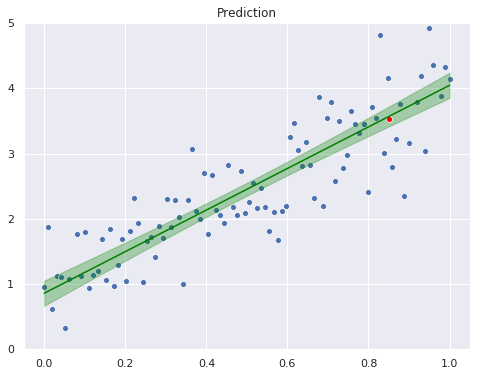

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green");

plt.fill_between(x=x.T.reshape(n,), 
                 y1=(y_hat.reshape(n,) - 2*y_hat_sd), 
                 y2=(y_hat.reshape(n,) + 2*y_hat_sd), 
                 color = "green", alpha = 0.3)

sns.scatterplot(x=x_star[1], y=y_hat_star, color="red");


ax.set_ylim((0,5));
ax.set_title("Prediction");

## Regularized Bayesian Linear Regression as a Gaussian Process 

A **Gaussian process** is a collection of random variables, any finite number of which have a joint Gaussian distribution (See  [Gaussian Processes for Machine Learning, Ch2 - Section 2.2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf)).

A Gaussian process \\(f(x) \\) is completely specified by its mean function \\(m(x)\\) and covariance function \\(k(x, x')\\). Here \\(x \in \mathcal{X}\\) denotes a point on the index set \\(\mathcal{X}\\). These functions are defined by

$$
m(x) = E[f(x)]
\quad
\text{and}
\quad
k(x, x') = E[(f(x) - m(x))(f(x') - m(x'))]
$$

**Claim:** The map \\(f(x) = x^T b \\) defines a Gaussian process. 

*Proof:*

1. Let \\(x_1, \cdots, x_N \in \mathcal{X}=\mathbb{R}^d\\). As \\(b\\) has a multivariate normal distribution, then every linear combination of its components is normally distributed (see [here](https://juanitorduz.github.io/multivariate_normal/)). In particular, for any \\(a_1, \cdots, a_N \in \mathbb{R}\\), we see that 

$$
\sum_{i=1}^N a_i f(x_i)
=
\sum_{i=1}^N a_i x_i^Tb
=
\left(\sum_{i=1}^N a_i x_i\right)^Tb
$$

is a linear combination of the components of \\(b\\), thus is normally distributed. This shows that \\(f(x)\\) is a Gaussian process. 

Let us now compute the mean and covariance functions:

2. \\(m (x) = E[f(x)] = x^T E[b]\\) = 0.


3. \\(k(x, x') = E[f(x)f(x')] = E[x^T b (x')^T b] = E[x^T b b^T x'] = x^T E[bb^T]x' = x^T \Sigma_px'\\).